In [7]:
import numpy as np
import networkx as nx
import random
import itertools
import matplotlib.pyplot as plt
import community
import graph_tool.all as gt

## Question 1

### Question 1a

In [20]:
ns = np.arange(50, 301, 50) # array of graph sizes
ms = [1,2,3,4,5] # list of m values 
modularity = {m : [] for m in ms} # dict to store mean modularity
modularity_error = {m : [] for m in ms} # dict to store std of modularity
for m in ms:
    for n in ns:
        mods = []
        for i in range(100):
            g = nx.barabasi_albert_graph(n, m)
            p = community.best_partition(g) # todo: simulated annealing?
            mods.append(community.modularity(p, g))
            mod = np.mean(mods)
        modularity[m].append(mod)
        modularity_error[m].append(np.std(mods))


<positron-console-cell-26>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


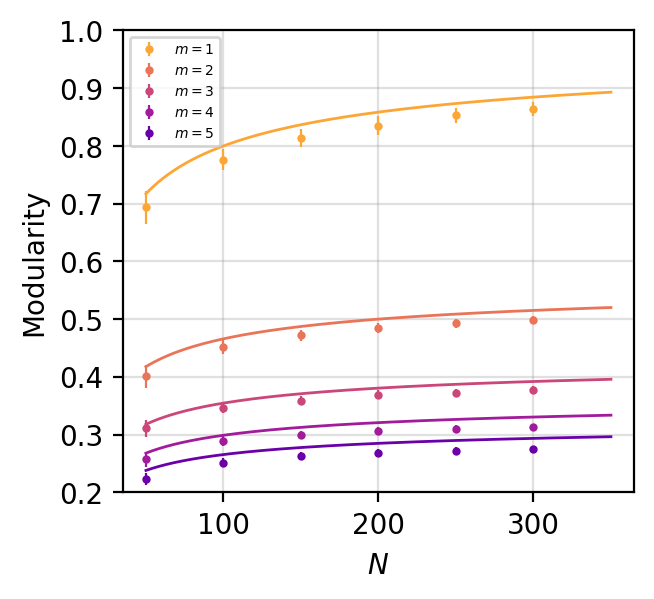

In [26]:
from matplotlib import cm
fig, ax = plt.subplots(1,1, figsize = (3.3,3), dpi = 200)
cols = [cm.get_cmap('plasma_r')(i) for i in np.linspace(0.2, 0.8, len(modularity.keys()))]
for k in modularity.keys():
    # ax.scatter(ns, modularity[k], s = 5, color = cols[k-1], label = r'$m =$' + str(k))
    ax.errorbar(
        ns, modularity[k], yerr=modularity_error[k], fmt='o', markersize=2,
        color=cols[k-1], label=r'$m =$' + str(k), capsize=0, capthick=0.8, elinewidth=0.8
    )
    n_vals = np.arange(50, 351, 1)
    a = 0.165
    m_vals = (a + (1-a)/k)*(1 - 2/np.sqrt(n_vals))
    ax.plot(n_vals, m_vals, color = cols[k-1], linewidth = 1)
ax.set_ylim(0.2,1)
ax.set_xlabel('$N$')
ax.set_ylabel('Modularity')
ax.grid(color = '#999999', alpha =0.3)
ax.legend(fontsize = 5)

plt.savefig('figs/modularity.pdf', dpi = 425, bbox_inches = 'tight')
plt.savefig('figs/modularity.png', dpi = 425, bbox_inches = 'tight')

### Question 1b

In [27]:
g_polblogs = gt.collection.data['polblogs']
g = gt.extract_largest_component(g_polblogs, directed=False)

In [39]:
state_ndc = gt.minimize_blockmodel_dl(g, state_args=dict(deg_corr = False), multilevel_mcmc_args=dict(B_max=2))
state_dc = gt.minimize_blockmodel_dl(g, state_args=dict(deg_corr = True), multilevel_mcmc_args=dict(B_max=2))


In [29]:
print("Number of blocks (deg_corr=False):", state_ndc.get_nonempty_B())
print("Number of blocks (deg_corr=True):", state_dc.get_nonempty_B())

Number of blocks (deg_corr=False): 2
Number of blocks (deg_corr=True): 2


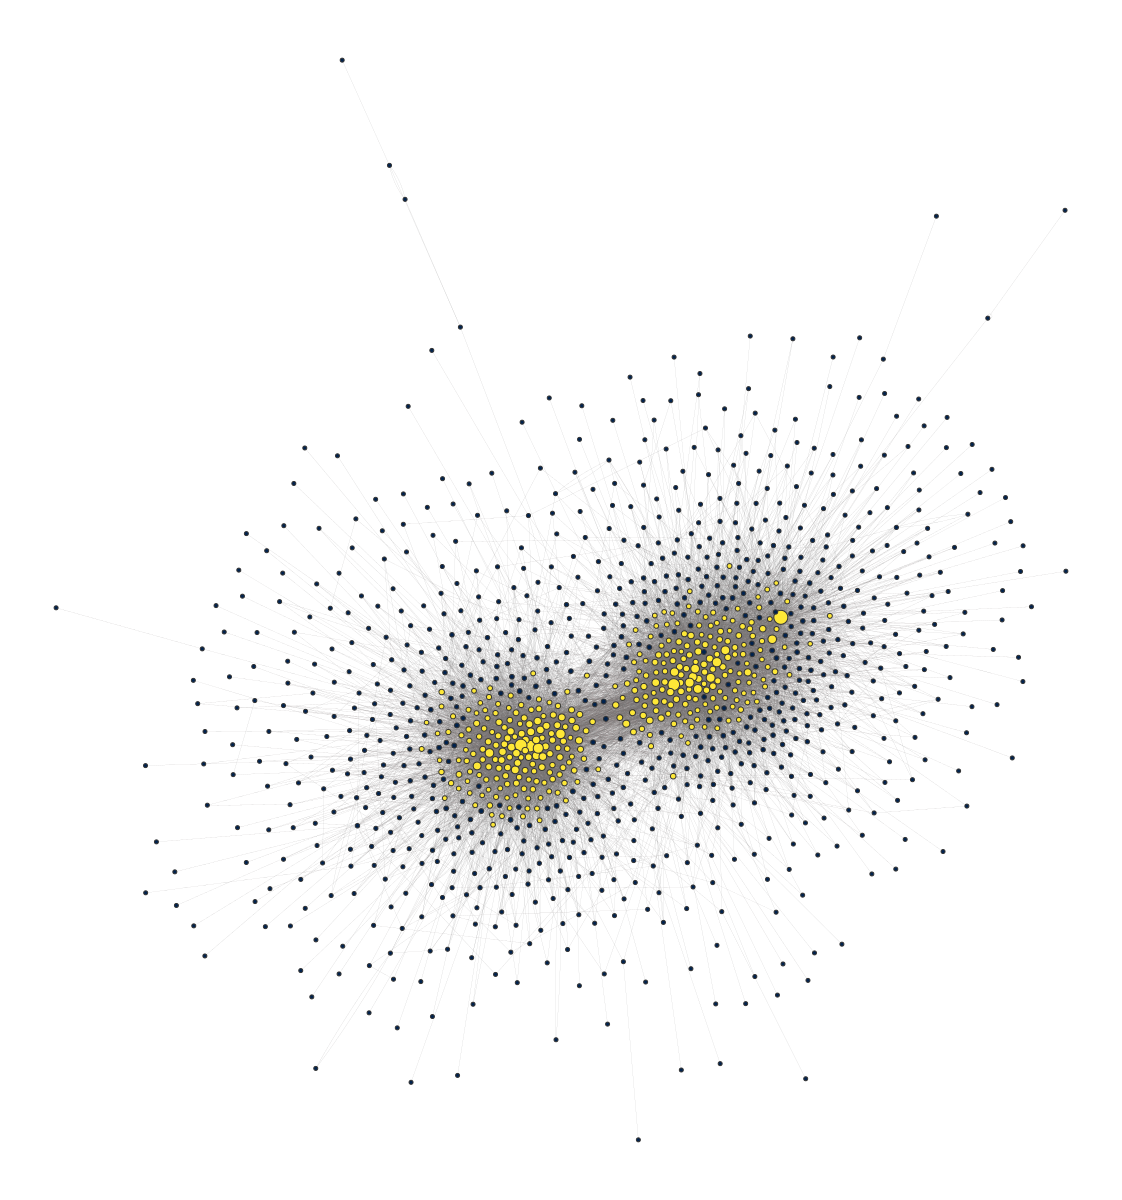

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x365e204a0, at 0x3679d3140>

In [117]:
import matplotlib
dprms = dict(fmt="png", output_size=(900, 900))
degree_property = g.degree_property_map("total")

# Normalize or scale the degrees to an appropriate size range
min_size = 2    # Minimum size for nodes
max_size = 7   # Maximum size for nodes

# Scale the degrees to the desired size range
degree_scaled = g.new_vertex_property("float")
for v in g.vertices():
    degree_scaled[v] = np.interp(degree_property[v], (degree_property.a.min(), degree_property.a.max()), (min_size, max_size))


state_ndc.draw(vertex_size = degree_scaled, edge_gradient = [], edge_color='#716f6f', edge_pen_width = 0.04, vertex_fill_color=state_ndc.b, 
               vcmap=matplotlib.cm.cividis_r, vcnorm=matplotlib.colors.Normalize(vmin=0.49, vmax=0.51),
               vertex_pen_width=0.5,  # Add outlines
               vertex_color='.2'
               )

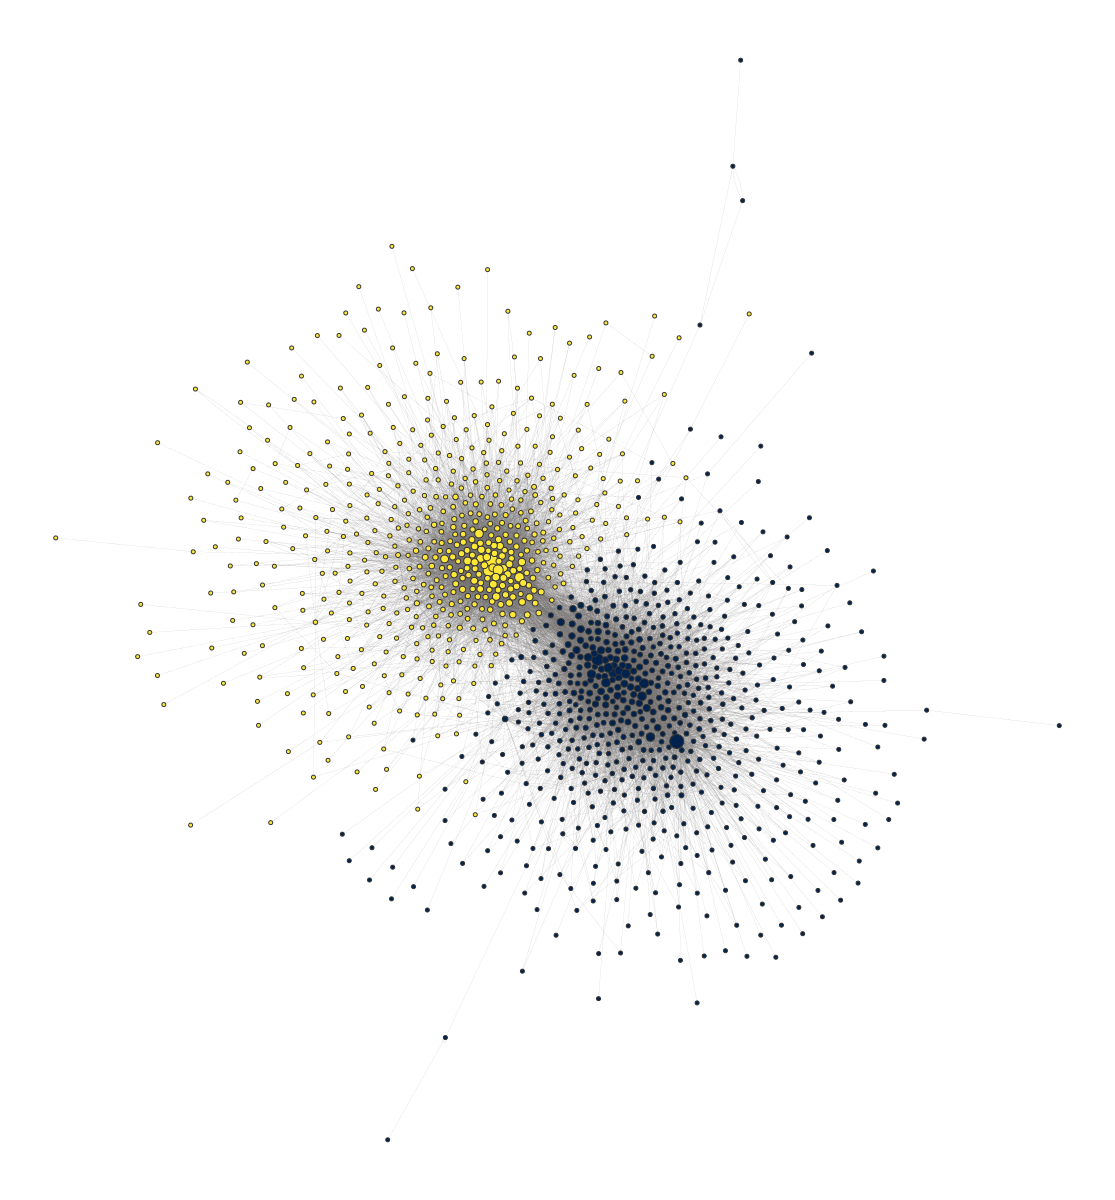

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x365e204a0, at 0x366f31be0>

In [116]:
dprms = dict(fmt="png", output_size=(900, 900))

degree_property = g.degree_property_map("total")

# Normalize or scale the degrees to an appropriate size range
min_size = 2    # Minimum size for nodes
max_size = 7   # Maximum size for nodes

# Scale the degrees to the desired size range
degree_scaled = g.new_vertex_property("float")
for v in g.vertices():
    degree_scaled[v] = np.interp(degree_property[v], (degree_property.a.min(), degree_property.a.max()), (min_size, max_size))


state_dc.draw(vertex_size = degree_scaled, edge_gradient = [], edge_color='#716f6f', edge_pen_width = 0.04, vertex_fill_color=state_dc.b, 
               vcmap=matplotlib.cm.cividis_r, vcnorm=matplotlib.colors.Normalize(vmin=0.49, vmax=0.51), 
               vertex_pen_width=0.5,  # Add outlines
               vertex_color='.2'
               )

### Question 1c

In [30]:
state_ndc.entropy()

83089.46810718774

In [31]:
state_dc.entropy()

63427.44508309492

In [40]:
# state_ndc = gt.BlockState(g, B=2, deg_corr=False)
# state_dc = gt.BlockState(g, B=2, deg_corr=True)

description_length_ndc = [state_ndc.entropy()]
description_length_dc = [state_dc.entropy()]

for i in range(1000):
    state_ndc.mcmc_sweep(beta=np.inf, niter=1)
    description_length_ndc.append(state_ndc.entropy())
    state_dc.mcmc_sweep(beta=np.inf, niter=1)
    description_length_dc.append(state_dc.entropy())


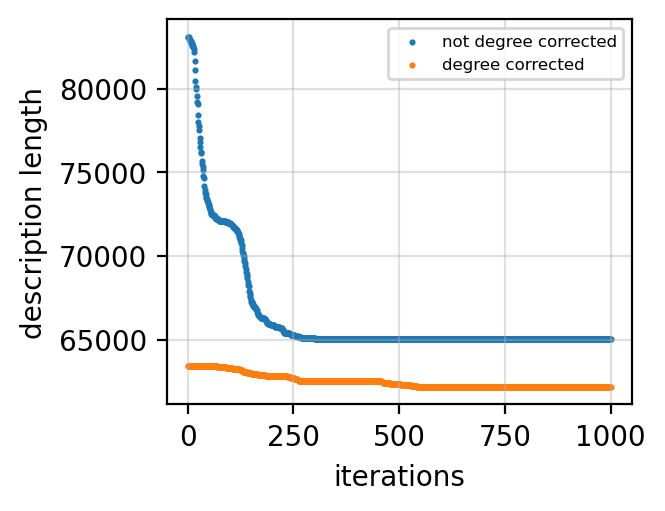

In [41]:
fig, ax = plt.subplots(1,1, figsize=(3,2.5), dpi = 200)
iterations = np.arange(0, 1001, 1)
ax.scatter(iterations, description_length_ndc, marker = 'o', s = 1.5, label = 'not degree corrected')
ax.scatter(iterations, description_length_dc, marker = 'o', s = 1.5, label = 'degree corrected')
ax.grid('#999999', alpha = 0.4)
ax.legend(fontsize = 6)
ax.set_xlabel('iterations')
ax.set_ylabel('description length')
plt.savefig('figs/description_length_mcmc.png', dpi = 425, bbox_inches = 'tight')
plt.savefig('figs/description_length_mcmc.pdf', dpi = 425, bbox_inches = 'tight')

### Question 1d

## Question 2

### Question 2a

### Question 2b

### Question 2c

## Question 3

### Question 3a

In [151]:
import random

In [43]:
def hitting_time(G, start_node, end_node):
    """
    Calculate the hitting time, or mean first passage time, between two nodes in a network.

    Parameters:
    G (networkx.Graph): The input graph.
    start_node (node): The node to start the random walk from.
    end_node (node): The node to end the random walk at.

    Returns:
    int: The hitting time between the start node and end node.

    Notes:
    The hitting time is calculated by performing a random walk from the start node to the end node.
    If the random walk reaches a dead end (i.e., a node with no neighbors), the function returns infinity.

    Examples:
    >>> G = nx.Graph([(1, 2), (2, 3), (3, 1)])
    >>> hitting_time(G, 1, 3)
    2
    """
    # path = [start_node]
    path_length = 0
    current_node = start_node
    # adj_dict = {node: list(neighbors.keys()) for node, neighbors in G.adj.items()}


    while True:
        neighbors = list(G.neighbors(current_node))
        # neighbors = adj_dict[current_node]

        if neighbors:
            next_node = random.choice(neighbors)
            # path.append(next_node)
            current_node = next_node
            path_length += 1
        else:
            print('Warning: Dead end')
            return float('inf')
        
        if current_node == end_node:
            break

    return path_length


In [44]:
def commute_time(G, start_node, end_node, iterations):
    """
    Calculate the commute time between two nodes in a network.

    The commute time is defined as the sum of the hitting time from the start node to the end node
    and the hitting time from the end node to the start node. This function calculates the commute time
    by performing multiple iterations of random walks between the two nodes.

    Parameters:
    G (networkx.Graph): The input graph.
    start_node (node): The node to start the random walk from.
    end_node (node): The node to end the random walk at.
    iterations (int): The number of iterations to perform.

    Returns:
    list: A list of commute times, one for each iteration.

    Notes:
    The commute time is calculated by calling the `hitting_time` function twice for each iteration,
    once for the outward journey and once for the inward journey. The results are then summed to give
    the commute time.
    
    Examples:
    >>> G = nx.Graph([(1, 2), (2, 3), (3, 1)])
    >>> commute_time(G, 1, 3, 10)
    [4, 6, 4, 6, 4, 6, 4, 6, 4, 6]
    """
    # commute_times = np.zeros(iterations)
    commute_times = []
    for i in range(iterations):
            
        out_time = hitting_time(G, start_node, end_node)
        in_time = hitting_time(G, end_node, start_node)
        
        # commute_times[i] = out_time + in_time
        commute_times.append(out_time + in_time)

    return commute_times
    


In [38]:
def commute_time_helper(G, start_node, end_node, iterations):
    """
    Same as commute_time() but returns the mean (for use with joblib)
    """
    commute_times = []
    for i in range(iterations):
            
        out_time = hitting_time(G, start_node, end_node)
        in_time = hitting_time(G, end_node, start_node)
        
        commute_times.append(out_time + in_time)

    return np.mean(commute_times)

In [45]:
g = nx.karate_club_graph()

for i in range(3):
    node_pair = np.random.choice(range(len(g.nodes())), 2)

    c_time = commute_time(g, node_pair[0], node_pair[1], 1)

    print('Commute time from node', node_pair[0], 'to node', node_pair[1], 'was', c_time)


Commute time from node 11 to node 4 was [115]
Commute time from node 30 to node 0 was [26]
Commute time from node 16 to node 18 was [332]


### Question 3b

In [50]:
er = nx.gnp_random_graph(500, 8 / (500 - 1))
node_pair = np.random.choice(range(len(er.nodes())), 2)
np.mean(commute_time(er, node_pair[0], node_pair[1], 1000))


np.float64(1714.096)

In [51]:
ba = nx.barabasi_albert_graph(500, 4)
node_pair = np.random.choice(range(len(ba.nodes())), 2)
np.mean(commute_time(ba, node_pair[0], node_pair[1], 1000))

np.float64(2237.234)

In [65]:
import numpy as np
import itertools
import networkx as nx
from joblib import Parallel, delayed
from tqdm import tqdm

In [68]:
mean_commute_time_whole_graph_er = np.zeros(10)
num_combinations = len(list(itertools.combinations(range(500), 2)))
mean_commute_time_whole_graph_er_distribution = np.zeros((10, num_combinations))
p = 8 / (500 - 1)

for i in range(10):
    print(i)
    er = nx.gnp_random_graph(500, p)
    while not nx.is_connected(er):
        er = nx.gnp_random_graph(500, p)
    all_node_pairs_er = list(itertools.combinations(er.nodes(), 2))
    
    # Set number of trials for each pair
    trials = 10

    # Use Parallel for joblib-based parallel execution
    all_commute_times_er = Parallel(n_jobs=5)(
        delayed(commute_time_helper)(er, u, v, trials) for u, v in all_node_pairs_er
    )

    # Store results
    mean_commute_time_whole_graph_er[i] = np.mean(all_commute_times_er)
    mean_commute_time_whole_graph_er_distribution[i] = all_commute_times_er

print(mean_commute_time_whole_graph_er)


0
1
2
3
4
5
6
7
8
9
[1331.0541483  1378.48265411 1390.87896754 1364.34473026 1354.95477515 1402.11218116 1355.70033267 1369.30395431 1322.67028297 1351.1735022 ]


In [544]:
# with open("data/mean_commute_time_whole_graph_er_distribution.pkl", "wb") as f:
#     pickle.dump(mean_commute_time_whole_graph_er_distribution, f)

with open("data/mean_commute_time_whole_graph_er_distribution.pkl", "rb") as f:
    mean_commute_time_whole_graph_er_distribution = pickle.load(f)

In [69]:
mean_commute_time_whole_graph_ba = np.zeros(10)
num_combinations = len(list(itertools.combinations(range(500), 2)))
mean_commute_time_whole_graph_ba_distribution = np.zeros((10, num_combinations))

for i in range(10):
    print(i)
    ba = nx.barabasi_albert_graph(500, 4)

    all_node_pairs_ba = list(itertools.combinations(ba.nodes(), 2))
    
    # Set number of trials for each pair
    trials = 10

    # Use Parallel for joblib-based parallel execution
    all_commute_times_ba = Parallel(n_jobs=5)(
        delayed(commute_time_helper)(ba, u, v, trials) for u, v in all_node_pairs_ba
    )

    # Store results
    mean_commute_time_whole_graph_ba[i] = np.mean(all_commute_times_ba)
    mean_commute_time_whole_graph_ba_distribution[i] = all_commute_times_ba

print(mean_commute_time_whole_graph_ba)

0
1
2
3
4
5
6
7
8
9
[1583.2327503  1564.2942012  1588.55459078 1576.94898918 1574.56686733 1590.78894108 1571.28652986 1587.1894998  1596.23858597
 1602.60425571]


In [ ]:
# with open("data/mean_commute_time_whole_graph_ba_distribution.pkl", "wb") as f:
#     pickle.dump(mean_commute_time_whole_graph_ba_distribution, f)

with open("data/mean_commute_time_whole_graph_ba_distribution.pkl", "rb") as f:
    mean_commute_time_whole_graph_ba_distribution = pickle.load(f)

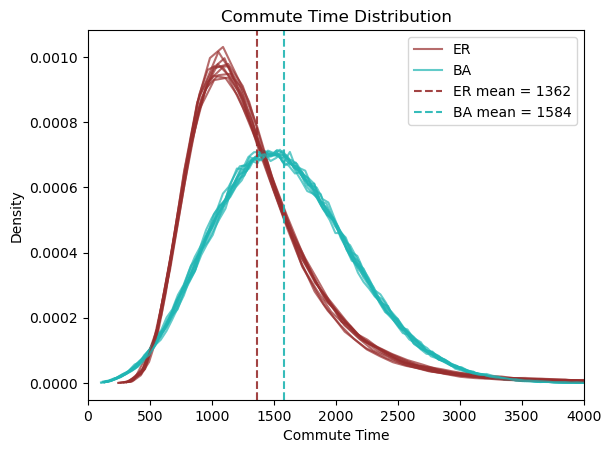

In [85]:
for i in range(10):

    # Compute histogram data
    counts, bin_edges = np.histogram(mean_commute_time_whole_graph_er_distribution[i], bins=100, density=True)

    # Compute bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot as a line
    plt.plot(bin_centers, counts, linestyle='-', marker='', color='#982e2e', label = 'ER' if i == 0 else None, alpha = 0.7)

    # Compute histogram data
    counts, bin_edges = np.histogram(mean_commute_time_whole_graph_ba_distribution[i], bins=100, density=True)

    # Compute bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot as a line
    plt.plot(bin_centers, counts, linestyle='-', marker='', color='#20b5b3', label = 'BA' if i == 0 else None, alpha = 0.7)
    # plt.plot(bins_ba[i], counts_ba[i], linestyle='-', marker='', color='#20b5b3', label = 'ER', alpha = 0.7)

plt.axvline(x=np.mean(mean_commute_time_whole_graph_er), color='#982e2e', alpha = 0.9, linestyle='--', linewidth=1.5, label="ER mean = "+str(round(np.mean(mean_commute_time_whole_graph_er))))
plt.axvline(x=np.mean(mean_commute_time_whole_graph_ba), color='#20b5b3', alpha = 0.9, linestyle='--', linewidth=1.5, label="BA mean = "+str(round(np.mean(mean_commute_time_whole_graph_ba))))

plt.xlim(0, 4000)
plt.legend()
plt.xlabel("Commute Time")
plt.ylabel("Density")
plt.title("Commute Time Distribution")

plt.savefig('figs/commute_time_distribution.png', dpi = 425, bbox_inches = 'tight')
plt.savefig('figs/commute_time_distribution.pdf', dpi = 425, bbox_inches = 'tight')

## Question 4

### Question 4a

### Question 4b

In [2]:
from torch.nn import Linear
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import CitationFull
import torch_geometric

# # loading the dataset
dataset = torch_geometric.datasets.CitationFull('data/', name='Cora')

In [52]:
import numpy as np
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import RandomNodeSplit

losses = []
accuracies = []
# checking if the GPU is available; else use the CPU. 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) # yell if you don't see 'cuda' here!

hidden_dims = [64, 32, 16]  # Define a list of dimensions for each hidden layer

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        # Define a list to hold all GCN layers
        self.gcn_layers = torch.nn.ModuleList()
        # Create each layer
        prev_dim = input_dim
        for dim in hidden_dims:
            self.gcn_layers.append(GCNConv(prev_dim, dim))
            prev_dim = dim
        # Final output layer
        self.out = Linear(prev_dim, output_dim)
    
    def forward(self, x, edge_index):
        for gcn_layer in self.gcn_layers:
            x = gcn_layer(x, edge_index).relu()
        z = self.out(x)
        return x, z


splits = RandomNodeSplit(split='train_rest', num_val=0.15, num_test=0.15)(dataset.data)
# this lets us make a mask on our dataset 
# such that we're only training the model on a subset of nodes.
# we have a validation set that we look at each epoch to track our accuracy
# as well as a test set that we can use to look at our performance at the end of training.

model = GCN(input_dim=dataset.num_features, hidden_dims=hidden_dims, output_dim=dataset.num_classes)

model.to(device) # puts it on the GPU

criterion = torch.nn.CrossEntropyLoss() 
# cross-entropy loss tells us how wrong given our final output 

optimizer = torch.optim.Adam(model.parameters(), lr=0.02) 
# you can mess with the learning rate or choice of optimizer
loader = DataLoader(dataset)

all_embeddings = []  # Initialize a list to store embeddings for each epoch

for epoch in range(1, 101):
    # Training step
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        h2, z = model(batch.x.to(device), batch.edge_index.to(device))
        loss = criterion(z[splits.train_mask], batch.y.to(device)[splits.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Evaluation step (collect embeddings here)
    model.eval()
    with torch.no_grad():
        # Get embeddings for all nodes in the dataset
        h2, val_z = model(dataset.x.to(device), dataset.edge_index.to(device))
        # Optionally, only store embeddings for nodes in the validation set
        val_embeddings = h2
        all_embeddings.append(val_embeddings.cpu().numpy())  # Store for each epoch

    # Print or store additional metrics if needed
    val_z = val_z[splits.val_mask]
    ans = val_z.argmax(dim=1)
    ys = dataset.y.to(device)[splits.val_mask]
    accuracy = torch.mean(torch.eq(ans, ys).float())
    loss = total_loss / len(loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

    losses.append(loss)
    accuracies.append(accuracy)

cpu


/opt/anaconda3/envs/phd2024/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch: 001, Loss: 4.2696, Accuracy: 0.0138
Epoch: 002, Loss: 4.2404, Accuracy: 0.0519
Epoch: 003, Loss: 4.0919, Accuracy: 0.0936
Epoch: 004, Loss: 3.9457, Accuracy: 0.1122
Epoch: 005, Loss: 3.7308, Accuracy: 0.1485
Epoch: 006, Loss: 3.5816, Accuracy: 0.1522
Epoch: 007, Loss: 3.4202, Accuracy: 0.2044
Epoch: 008, Loss: 3.2362, Accuracy: 0.2428
Epoch: 009, Loss: 3.0798, Accuracy: 0.2961
Epoch: 010, Loss: 2.9107, Accuracy: 0.3425
Epoch: 011, Loss: 2.7186, Accuracy: 0.3755
Epoch: 012, Loss: 2.5566, Accuracy: 0.4254
Epoch: 013, Loss: 2.4058, Accuracy: 0.4382
Epoch: 014, Loss: 2.3038, Accuracy: 0.4517
Epoch: 015, Loss: 2.1989, Accuracy: 0.4995
Epoch: 016, Loss: 2.0238, Accuracy: 0.5133
Epoch: 017, Loss: 1.9815, Accuracy: 0.5099
Epoch: 018, Loss: 1.8834, Accuracy: 0.5379
Epoch: 019, Loss: 1.7612, Accuracy: 0.5564
Epoch: 020, Loss: 1.6936, Accuracy: 0.5652
Epoch: 021, Loss: 1.6345, Accuracy: 0.5820
Epoch: 022, Loss: 1.5607, Accuracy: 0.6083
Epoch: 023, Loss: 1.4873, Accuracy: 0.6083
Epoch: 024,

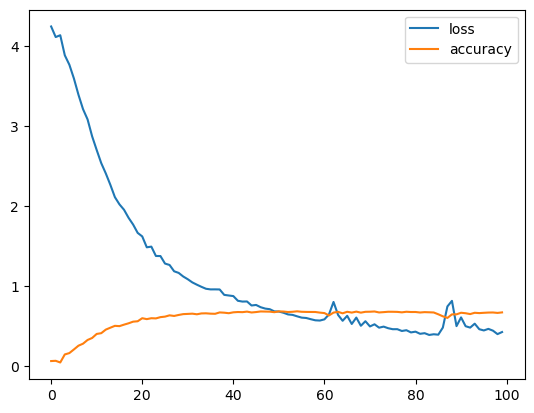

In [90]:
import matplotlib.pyplot as plt
plt.plot(losses, label='loss')
plt.plot(accuracies, label='accuracy')
plt.legend()

### Question 4c

100it [06:12,  3.73s/it]


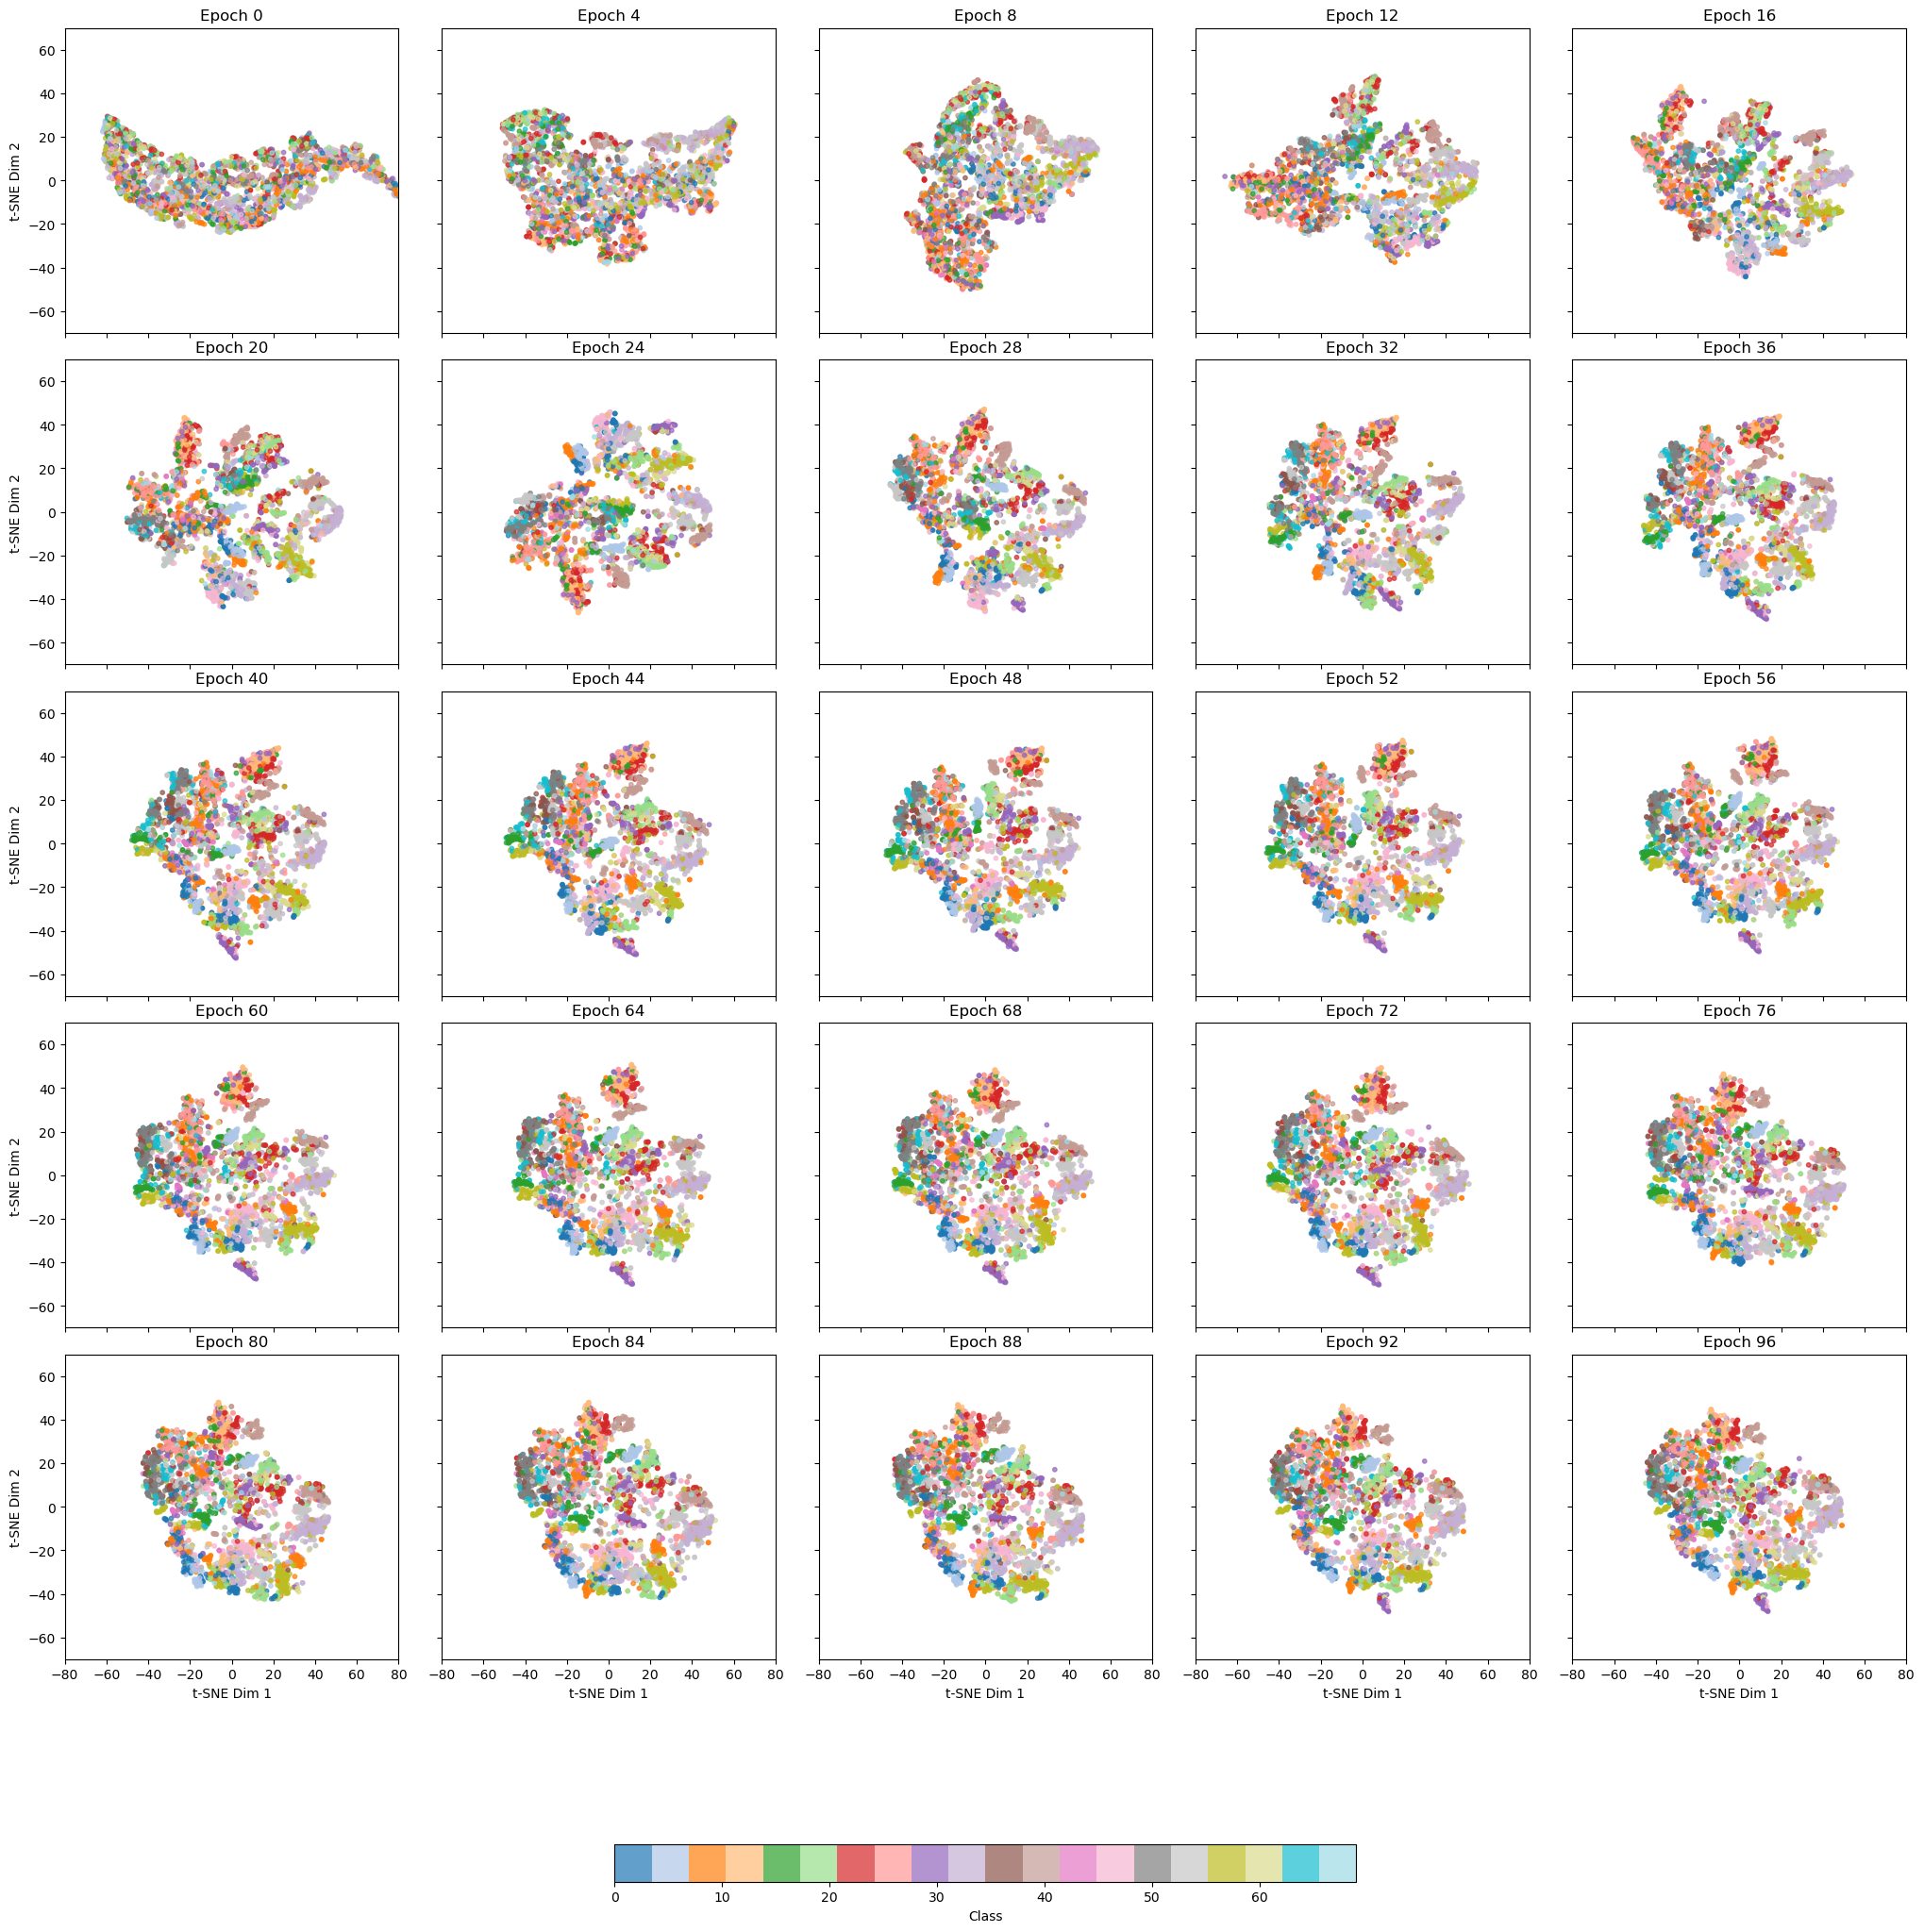

In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import os
os.environ["OPENBLAS_NUM_THREADS"] = "4"

# Number of epochs 
num_epochs = 100

k = 0
rows, cols = 5, 5
indices = list(itertools.product(range(rows), range(cols)))
# Initialize a subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
fig.tight_layout(pad=0.2)  

# Plot embeddings for each epoch on a different subplot
for epoch, embeddings in tqdm(enumerate(all_embeddings)):

    if epoch % 4 == 0: # control how often to plot
        # Perform t-SNE to reduce embeddings to 2 dimensions for visualization
        tsne = TSNE(n_components=2, random_state=42, perplexity=50, max_iter=1000)  # Adjust perplexity based on dataset size
        reduced_embeddings = tsne.fit_transform(embeddings)
        # Determine subplot position
        x, y = indices[k]
        ax = axes[x, y]
        scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                            c=dataset.y[splits.val_mask], cmap='tab20', alpha=0.7, s=10)
        
        ax.set_title(f'Epoch {epoch}')
        ax.set_xlabel('t-SNE Dim 1')
        ax.set_ylabel('t-SNE Dim 2')
        ax.set_xlim(-80,80)
        ax.set_ylim(-70,70)
        ax.label_outer()  # Hide x and y labels on inner subplots for cleaner appearance
        k+=1

# Add a single colorbar for the entire figure
fig.colorbar(scatter, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1, label='Class')
plt.savefig('/Users/nima/Desktop/PhD/PHYS 7332/assignment03/figs/tsne_embeddings2.pdf', bbox_inches='tight', dpi = 425)
plt.savefig('/Users/nima/Desktop/PhD/PHYS 7332/assignment03/figs/tsne_embeddings2.png', bbox_inches='tight', dpi = 425)
plt.show()

### Question 4d

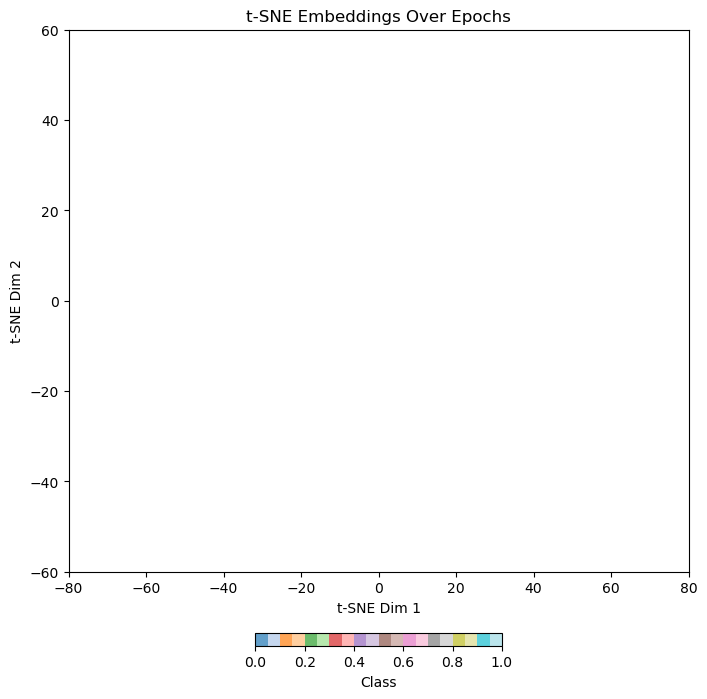

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
# from tqdm import tqdm  # Progress bar
import os
os.environ["OPENBLAS_NUM_THREADS"] = "4"

fig, ax = plt.subplots(figsize=(8, 8))

scatter = ax.scatter([], [], c=[], cmap='tab20', alpha=0.7, s=10)
colorbar = fig.colorbar(scatter, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, label='Class')

# Function to initialize the animation
def init():
    ax.clear()
    ax.set_title("t-SNE Embeddings Over Epochs")
    ax.set_xlabel("t-SNE Dim 1")
    ax.set_ylabel("t-SNE Dim 2")
    ax.set_xlim(-80,80)
    ax.set_ylim(-60,60)
    return scatter,

# Function to update each frame of the animation
def update(epoch):
    ax.clear()  # Clear the subplot to refresh with new data
    ax.set_title(f'Epoch {epoch}')
    ax.set_xlabel("t-SNE Dim 1")
    ax.set_ylabel("t-SNE Dim 2")

    # Perform t-SNE to reduce embeddings to 2D for visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=50, max_iter=1000)
    reduced_embeddings = tsne.fit_transform(all_embeddings[epoch])
    
    # Update the scatter plot with the new embeddings
    scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                         c=dataset.y[splits.val_mask], cmap='tab20', alpha=0.7, s=10)
    ax.set_xlim(-80,80)
    ax.set_ylim(-60,60)
    
    return scatter,

# 
epochs_to_update = list(range(0, len(all_embeddings), 4))

# Create the animation
ani = FuncAnimation(fig, update, frames=epochs_to_update, init_func=init, repeat=False)

# Save or show the animation
ani.save('/Users/nima/Desktop/PhD/PHYS 7332/assignment03/figs/tsne_embeddings_animation2.gif', fps=5, dpi=300, writer='pillow')
